In [1]:
# Libraries
from bs4 import BeautifulSoup, Comment
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import random
import urllib
import urllib2
import os
import re
import scipy.stats as stats
import unicodedata
import datetime
from datetime import date
from time import strptime
import requests
import requests_cache
requests_cache.install_cache('demo_cache')
%matplotlib inline

## Get each player on a roster's stats from last year

In [2]:
yr = 2017
team = 'BOS'
link = 'https://www.basketball-reference.com/teams/' + team + '/' + str(yr) + '.html'
page = urllib.urlopen(link).read()
soup = BeautifulSoup(page, "lxml")

In [3]:
roster = soup.find_all('table')[0]

In [4]:
trs = roster.find_all('tr')

In [5]:
trs[1].find_all('a')[0]['href']

'/players/b/bradlav01.html'

In [6]:
players = []
for tr in trs[1:]:
    players.append(tr.find_all('a')[0]['href'])

In [7]:
tail = players[0].split('/')
p_id = tail[3].split('.')[0]

In [8]:
p_id

'bradlav01'

In [9]:
players

['/players/b/bradlav01.html',
 '/players/b/brownja02.html',
 '/players/c/crowdja01.html',
 '/players/g/greenge01.html',
 '/players/h/horfoal01.html',
 '/players/j/jacksde01.html',
 '/players/j/jerebjo01.html',
 '/players/j/johnsam01.html',
 '/players/m/mickejo01.html',
 '/players/o/olynyke01.html',
 '/players/r/roziete01.html',
 '/players/s/smartma01.html',
 '/players/t/thomais02.html',
 '/players/y/youngja01.html',
 '/players/z/zellety01.html']

In [10]:
player_links = ['https://www.basketball-reference.com' + tail for tail in players]

In [11]:
tails = [link.split('/')[3] for link in players]
player_ids = [tail.split('.')[0] for tail in tails]
player_ids

['bradlav01',
 'brownja02',
 'crowdja01',
 'greenge01',
 'horfoal01',
 'jacksde01',
 'jerebjo01',
 'johnsam01',
 'mickejo01',
 'olynyke01',
 'roziete01',
 'smartma01',
 'thomais02',
 'youngja01',
 'zellety01']

In [12]:
player_links

['https://www.basketball-reference.com/players/b/bradlav01.html',
 'https://www.basketball-reference.com/players/b/brownja02.html',
 'https://www.basketball-reference.com/players/c/crowdja01.html',
 'https://www.basketball-reference.com/players/g/greenge01.html',
 'https://www.basketball-reference.com/players/h/horfoal01.html',
 'https://www.basketball-reference.com/players/j/jacksde01.html',
 'https://www.basketball-reference.com/players/j/jerebjo01.html',
 'https://www.basketball-reference.com/players/j/johnsam01.html',
 'https://www.basketball-reference.com/players/m/mickejo01.html',
 'https://www.basketball-reference.com/players/o/olynyke01.html',
 'https://www.basketball-reference.com/players/r/roziete01.html',
 'https://www.basketball-reference.com/players/s/smartma01.html',
 'https://www.basketball-reference.com/players/t/thomais02.html',
 'https://www.basketball-reference.com/players/y/youngja01.html',
 'https://www.basketball-reference.com/players/z/zellety01.html']

### For individual player

In [13]:
player_ids[0], player_ids[4]

('bradlav01', 'horfoal01')

In [14]:
player = player_ids[4]

In [15]:
player

'horfoal01'

In [16]:
season_df = pd.read_excel('data/season_data/season_data_' + str(yr-1) + '.xlsx')

In [17]:
old_team = season_df[season_df['id'] == player]['team'].values[0]

In [18]:
team_df = season_df[season_df['team'] == old_team]

In [19]:
team_df.head()

,G,GS,age,ast,blk,drb,efg,fg,fg2,fg2_pct,...,player,pos,pts,stl,team,tov,trb,yr,weighted_usg,prev_weighted_usg
44,75,68,26,171,38,351,0.517,320,211,0.502,...,Kent Bazemore,SF,872,98,ATL,138,379,2016,0.105123,0.059705
204,51,1,23,51,7,79,0.521,114,66,0.537,...,Tim Hardaway,SG,326,21,ATL,23,86,2016,0.039479,0.093083
234,11,0,35,14,1,11,0.227,2,1,0.200,...,Kirk Hinrich,PG,5,2,ATL,3,12,2016,0.002709,0.067580
237,26,1,26,11,4,23,0.397,24,14,0.500,...,Justin Holiday,SG,63,13,ATL,13,27,2016,0.011748,0.032338
245,82,82,29,263,121,448,0.547,529,441,0.557,...,Al Horford,C,1249,68,ATL,107,596,2016,0.134918,0.124533


In [20]:
team_df['id']

44     bazemke01
204    hardati02
234    hinriki01
237    holidju01
245    horfoal01
252    humphkr01
305    korveky01
335     macksh01
375    millspa01
392    muscami01
419    pattela01
467    schrode01
469    scottmi01
470    sefolth01
491    splitti01
505    tavarwa01
506    teaguje01
Name: id, dtype: object

#### Functions

In [21]:
# Function for calculating usage rate for a team
# team_df: a dataframe of a single team's season statistics
def calculate_weighted_off_usg_2(team_df):
    # Multiply by MP to weight Gini, essentially MP in numerator and denominator cancel
    weighted_off = [(100 * ((fga + 0.44*fta + tov))) / 
                ((sum(team_df['fga']) + 0.44*sum(team_df['fta']) + sum(team_df['tov'])))
    for fga, fta, tov, mp in zip(team_df['fga'], team_df['fta'], team_df['tov'], team_df['mp'])]
    return weighted_off

In [22]:
def calculate_weighted_def_usg_2(team_df):
    weighted_def = [float(mp)/(sum(team_df['mp'])/5) * 20 for mp in team_df['mp']]
    return weighted_def

In [23]:
def calculate_weighted_usg_2(team_df):
    off_usg = calculate_weighted_off_usg_2(team_df)
    def_usg = calculate_weighted_def_usg_2(team_df)
    weighted_usg = [(o_usg + d_usg)/2 for o_usg, d_usg in zip(off_usg, def_usg)]
    return zip(team_df['id'], [w/100 for w in weighted_usg])

In [24]:
usgs = calculate_weighted_usg_2(team_df)
usg_dict = {k:v for k, v in usgs}

In [25]:
usg_dict

{u'bazemke01': 0.10512298604275391,
 u'hardati02': 0.0394790001555409,
 u'hinriki01': 0.002708616901412335,
 u'holidju01': 0.011747544604900932,
 u'horfoal01': 0.13491830348790004,
 u'humphkr01': 0.015067215983340146,
 u'korveky01': 0.1022930319819814,
 u'macksh01': 0.010981027534594609,
 u'millspa01': 0.14804199994463688,
 u'muscami01': 0.02534774525641559,
 u'pattela01': 0.01633676920649141,
 u'schrode01': 0.0999620075055086,
 u'scottmi01': 0.05412108674681055,
 u'sefolth01': 0.07169380225788846,
 u'splitti01': 0.025924861522152308,
 u'tavarwa01': 0.003398136838937331,
 u'teaguje01': 0.13288107835046925}

In [26]:
sum([usg[1] for usg in usgs])

1.0000252143217347

In [27]:
usg_dict[player]

0.13491830348790004

In [28]:
def get_last_year_usg(player, season_df):
    try:
        old_team = season_df[season_df['id'] == player]['team'].values[-1]
        team_df = season_df[season_df['team'] == old_team]
        usgs = calculate_weighted_usg_2(team_df)
        usg_dict = {k:v for k, v in usgs}
        #print player, usg_dict[player]
        return usg_dict[player]
    except IndexError:
        #print player
        return None

In [29]:
get_last_year_usg('chalmma01', season_df)

0.06701222655149981

In [30]:
yr = 2017
team = 'BOS'
link = 'https://www.basketball-reference.com/teams/' + team + '/' + str(yr) + '.html'
page = urllib.urlopen(link).read()
soup = BeautifulSoup(page, "lxml")
roster = soup.find_all('table')[0]
trs = roster.find_all('tr')
players = []
for tr in trs[1:]:
    players.append(tr.find_all('a')[0]['href'])
tails = [link.split('/')[3] for link in players]
player_ids = [tail.split('.')[0] for tail in tails]
player_ids

['bradlav01',
 'brownja02',
 'crowdja01',
 'greenge01',
 'horfoal01',
 'jacksde01',
 'jerebjo01',
 'johnsam01',
 'mickejo01',
 'olynyke01',
 'roziete01',
 'smartma01',
 'thomais02',
 'youngja01',
 'zellety01']

In [31]:
season_df = pd.read_excel('data/season_data/season_data_' + str(yr-1) + '.xlsx')

In [32]:
old_usgs = []
for player in player_ids:
    old_usgs.append(get_last_year_usg(player, season_df))

In [33]:
old_usgs

[0.1278604475523315,
 None,
 0.11233733253134819,
 0.07835468694075699,
 0.13491830348790004,
 None,
 0.04980733557964851,
 0.07641706472137119,
 0.002918613841042461,
 0.07227819584107796,
 0.014840407847252428,
 0.07892299450595269,
 0.16614527598238232,
 0.007336509215852587,
 0.03863180997295514]

In [34]:
old_usgs = [usg for usg in old_usgs if usg != None]

In [35]:
print sum(old_usgs)
old_usgs

0.96076897802


[0.1278604475523315,
 0.11233733253134819,
 0.07835468694075699,
 0.13491830348790004,
 0.04980733557964851,
 0.07641706472137119,
 0.002918613841042461,
 0.07227819584107796,
 0.014840407847252428,
 0.07892299450595269,
 0.16614527598238232,
 0.007336509215852587,
 0.03863180997295514]

In [36]:
# Take weighted usage rates, normalize them (sum = 1), sort them
def get_norm_usg(w_usg):
    return sorted([u/sum(w_usg) for u in w_usg])

In [37]:
# Subset only the top k usages, renormalize them
def get_norm_top_k(n_usg, k):
    new_usg = n_usg[-k:]
    return get_norm_usg(new_usg)

In [38]:
def get_gini(n_usg_k):
    x = range(len(n_usg_k)+1)
    y1 = np.cumsum([0] + n_usg_k)
    y2 = [float(t)/(len(x)-1) for t in x]
    gini = 2*(np.trapz(y2) - np.trapz(y1))/(x[-1]*y1[-1]) * len(n_usg_k)/(len(n_usg_k)-1)
    return gini

In [39]:
n_usg = get_norm_usg(old_usgs)

In [40]:
n_usg_k = get_norm_top_k(n_usg, 9)

In [41]:
n_usg_k

[0.055523995227572016,
 0.08057395871979404,
 0.08518786816270044,
 0.08734788185566285,
 0.0879814171807408,
 0.1252309010863328,
 0.14253568871071454,
 0.1504036132789085,
 0.18521467577757414]

In [42]:
get_gini(n_usg_k)

0.22020758655101233

In [43]:
def get_gini_pred(team, yr):
    link = 'https://www.basketball-reference.com/teams/' + team + '/' + str(yr) + '.html'
    page = urllib.urlopen(link).read()
    soup = BeautifulSoup(page, "lxml")
    roster = soup.find_all('table')[0]
    trs = roster.find_all('tr')
    players = []
    for tr in trs[1:]:
        players.append(tr.find_all('a')[0]['href'])
    tails = [link.split('/')[3] for link in players]
    player_ids = [tail.split('.')[0] for tail in tails]
    player_ids

    # Prediction for next year
    season_df = pd.read_excel('data/season_data/season_data_' + str(yr-1) + '.xlsx')
    old_usgs = []
    for player in player_ids:
        old_usgs.append(get_last_year_usg(player, season_df))
    #old_usgs = [usg for usg in old_usgs if usg != None]
    #old_usgs = [1./len(old_usgs) if usg is None else usg for usg in old_usgs]
    num_nones = sum([usg == None for usg in old_usgs])
    total = sum(filter(None, old_usgs))
    old_usgs = [(1 - total)/float(num_nones) if usg is None else usg for usg in old_usgs]
    
    n_usg = get_norm_usg(old_usgs)
    print n_usg
    n_usg_k = get_norm_top_k(n_usg, 9)
    gini_pred = get_gini(n_usg_k)

    gini_df = pd.read_excel('data/nba_results_gini_new.xlsx')
    gini_true = gini_df[(gini_df['alt_abbr'] == team) & (gini_df['yr'] == yr)]['gini'].values[0]

    return gini_pred, gini_true

In [44]:
prev_cor = []
pred_cor = []
for yr in range(2003,2018):
    season_df = pd.read_excel('data/season_data/season_data_' + str(yr) + '_preds.xlsx')
    season_df = season_df[season_df['prev_weighted_usg'] == season_df['prev_weighted_usg']]
    prev_cor.append(np.corrcoef(season_df['weighted_usg'], season_df['prev_weighted_usg'])[0][1])
    pred_cor.append(np.corrcoef(season_df['weighted_usg'], season_df['weighted_usg_pred'])[0][1])

In [45]:
np.mean(prev_cor), np.mean(pred_cor)

(0.65940073131219179, 0.67704644130853331)

In [46]:
yr = 2011
team = 'ATL'
link = 'https://www.basketball-reference.com/teams/' + team + '/' + str(yr) + '.html'
page = urllib.urlopen(link).read()
soup = BeautifulSoup(page, "lxml")
roster = soup.find_all('table')[0]
trs = roster.find_all('tr')
players = []
for tr in trs[1:]:
    players.append(tr.find_all('a')[0]['href'])
tails = [link.split('/')[3] for link in players]
player_ids = [tail.split('.')[0] for tail in tails]
print player_ids

season_df = pd.read_excel('data/season_data/season_data_' + str(yr) + '_preds.xlsx')
pred_usgs = []
for player in player_ids:
    if len(season_df[season_df['id'] == player]) == 0:
        pred_usgs.append(float('nan'))
    else:
        pred_usgs.append(season_df[season_df['id'] == player]['weighted_usg_pred'].values[-1])
pred_usgs = [1./len(pred_usgs) if usg != usg else usg for usg in pred_usgs]
print sorted(pred_usgs)

n_usg = get_norm_usg(pred_usgs)
print sorted(n_usg)
n_usg_k = get_norm_top_k(n_usg, 9)
gini_pred = get_gini(n_usg_k)

gini_df = pd.read_excel('data/nba_results_gini_new.xlsx')
gini_true = gini_df[(gini_df['alt_abbr'] == team) & (gini_df['yr'] == yr)]['gini'].values[0]

print gini_pred, gini_true

['armsthi01', 'bibbymi01', 'collija04', 'crawfja01', 'crawfjo02', 'evansma01', 'hinriki01', 'horfoal01', 'johnsjo02', 'pachuza01', 'poweljo01', 'smithjo03', 'sypa01', 'teaguje01', 'thomaet01', 'wilkida02', 'willima02']
[0.01037251772770045, 0.016457549891581338, 0.034729859844155928, 0.047080618918832633, 0.052043118121260022, 0.052756032743146691, 0.05570524067838438, 0.058823529411764705, 0.058823529411764705, 0.058823529411764705, 0.075027433888630632, 0.088818705431497114, 0.098708689198302391, 0.1078266796450945, 0.1152828352498274, 0.1252841960025555, 0.12776572241042389]
[0.0087581329397560057, 0.013896087102190102, 0.029324483937193956, 0.039752963571800207, 0.043943096466172005, 0.044545052635068673, 0.047035244104668722, 0.049668200537083797, 0.049668200537083797, 0.049668200537083797, 0.063350119746776151, 0.074994909637868132, 0.083345610487517333, 0.091044471513627573, 0.097340146654424337, 0.10578488971009806, 0.10788018988158736]
0.167764918512 0.283416457466


In [47]:
len(season_df[season_df['id'] == 'sypa01'])

0

In [48]:
for player in player_ids:
    print player, season_df[season_df['id'] == player]['weighted_usg_pred'].values[-1]

armsthi01 nan
bibbymi01 0.0750274338886
collija04 0.0103725177277
crawfja01 0.107826679645
crawfjo02 nan
evansma01 0.0470806189188
hinriki01 0.0888187054315
horfoal01 0.11528283525
johnsjo02 0.12776572241
pachuza01 0.0527560327431
poweljo01 0.0347298598442
smithjo03 0.125284196003
sypa01

IndexError: index -1 is out of bounds for axis 0 with size 0

In [246]:
def get_gini_pred_2(team, yr):
    link = 'https://www.basketball-reference.com/teams/' + team + '/' + str(yr) + '.html'
    page = urllib.urlopen(link).read()
    soup = BeautifulSoup(page, "lxml")
    roster = soup.find_all('table')[0]
    trs = roster.find_all('tr')
    players = []
    for tr in trs[1:]:
        players.append(tr.find_all('a')[0]['href'])
    tails = [link.split('/')[3] for link in players]
    player_ids = [tail.split('.')[0] for tail in tails]
    #print player_ids

    df = pd.read_excel('data/season_data/season_data_full.xlsx')
    season_df = df[df['yr'] == yr]
    pred_usgs = []
    for player in player_ids:
        if len(season_df[season_df['id'] == player]) == 0:
            pred_usgs.append(float('nan'))
        else:
            pred_usgs.append(season_df[season_df['id'] == player]['full_preds'].values[-1])
    #pred_usgs = [usg for usg in pred_usgs if usg == usg]
    #print pred_usgs
    pred_usgs = [1./len(pred_usgs) if usg != usg else usg for usg in pred_usgs]
    
    n_usg = get_norm_usg(pred_usgs)
    #print n_usg
    n_usg_k = get_norm_top_k(n_usg, 9)
    #print n_usg_k
    gini_pred = get_gini(n_usg_k)

    gini_df = pd.read_excel('data/nba_results_gini_new.xlsx')
    gini_true = gini_df[(gini_df['alt_abbr'] == team) & (gini_df['yr'] == yr)]['gini'].values[0]

    return gini_pred, gini_true

In [243]:
x = [5, 6,None,8]
sum(filter(None, x))
sum([usg == None for usg in x])

1

In [244]:
yr = 2005
team = 'CHI'
pred, true = get_gini_pred_2(team, yr)
print pred, true

[0.10294581013254095, 0.10294581013254095, 0.10294581013254095, 0.10294581013254095, 0.10294581013254095, 0.10294581013254095, 0.10294581013254095, 0.10294581013254095, 0.17643351893967238]
0.0734877088071 0.143957036026


In [52]:
true

0.134057590666324

In [53]:
s_res = pd.read_excel('data/nba_results_gini_new.xlsx')

In [54]:
s_res_short = s_res[s_res['yr'] >= 2003]

In [55]:
s_res.head()

,Team,W,L,WL_pct,PW,PL,PS/G,PA/G,yr,abbr,playoffs,gini,alt_abbr
0,Boston Celtics,53,29,0.646,48,34,108.0,105.4,2017,BOS,3,0.211476,BOS
1,Cleveland Cavaliers,51,31,0.622,49,33,110.3,107.2,2017,CLE,4,0.292304,CLE
2,Toronto Raptors,51,31,0.622,52,30,106.9,102.6,2017,TOR,2,0.258728,TOR
3,Washington Wizards,49,33,0.598,46,36,109.2,107.4,2017,WAS,2,0.329842,WAS
4,Atlanta Hawks,43,39,0.524,39,43,103.2,104.0,2017,ATL,1,0.239535,ATL


In [247]:
gini_preds_df = pd.DataFrame()
for i in range(len(s_res_short)):
    print s_res.iloc[i].abbr, s_res_short.iloc[i].yr
    pred, true = get_gini_pred_2(s_res_short.iloc[i].alt_abbr, s_res_short.iloc[i].yr)
    gini_preds_df = gini_preds_df.append({
            'team': s_res_short.iloc[i].abbr,
            'yr': s_res_short.iloc[i].yr,
            'gini_pred': pred,
            'gini_true': true
        }, ignore_index = True)
    

BOS 2017
CLE 2017
TOR 2017
WAS 2017
ATL 2017
MIL 2017
IND 2017
CHI 2017
MIA 2017
DET 2017
CHH 2017
NYK 2017
ORL 2017
PHI 2017
BRK 2017
GSW 2017
SAS 2017
HOU 2017
UTA 2017
LAC 2017
OKC 2017
MEM 2017
POR 2017
DEN 2017
NOP 2017
DAL 2017
SAC 2017
MIN 2017
LAL 2017
PHO 2017
CLE 2016
TOR 2016
MIA 2016
ATL 2016
CHH 2016
BOS 2016
IND 2016
DET 2016
CHI 2016
WAS 2016
ORL 2016
MIL 2016
NYK 2016
BRK 2016
PHI 2016
GSW 2016
SAS 2016
OKC 2016
LAC 2016
POR 2016
DAL 2016
MEM 2016
HOU 2016
UTA 2016
DEN 2016
SAC 2016
NOP 2016
MIN 2016
PHO 2016
LAL 2016
TOR 2015
BOS 2015
BRK 2015
PHI 2015
NYK 2015
CLE 2015
CHI 2015
MIL 2015
IND 2015
DET 2015
ATL 2015
WAS 2015
MIA 2015
CHH 2015
ORL 2015
POR 2015
OKC 2015
UTA 2015
DEN 2015
MIN 2015
GSW 2015
LAC 2015
PHO 2015
SAC 2015
LAL 2015
HOU 2015
MEM 2015
SAS 2015
DAL 2015
NOP 2015
TOR 2014
BRK 2014
NYK 2014
BOS 2014
PHI 2014
IND 2014
CHI 2014
CLE 2014
DET 2014
MIL 2014
MIA 2014
WAS 2014
CHH 2014
ATL 2014
ORL 2014
OKC 2014
POR 2014
MIN 2014
DEN 2014
UTA 2014
LAC 2014
G

In [248]:
diff = [true - pred for true, pred in zip(gini_preds_df['gini_true'], gini_preds_df['gini_pred'])]
gini_preds_df['diff'] = diff

In [250]:
#iqr = np.percentile(gini_preds_df['gini_true'], 75) - np.percentile(gini_preds_df['gini_true'], 25)
#ubound = np.median(gini_preds_df['gini_true']) + 1.5*iqr
#lbound = np.median(gini_preds_df['gini_true']) - 1.5*iqr

In [251]:
#outlier = [False if ((gini > lbound) & (gini < ubound)) else True for gini in gini_preds_df['gini_true']]

In [252]:
#gini_preds_df['outlier'] = outlier

In [253]:
len(gini_preds_df)

448

In [254]:
#gini_preds_no_out = gini_preds_df[gini_preds_df['outlier'] == False]

In [255]:
#len(gini_preds_no_out)

In [256]:
#np.percentile(gini_preds_df['gini_true'], 50) - 1.5*np.percentile(gini_preds_df['gini_true'], 25)

-0.063196825455190841

In [257]:
gini_preds_df.sort_values(['diff'])

,gini_pred,gini_true,team,yr,diff
63,0.262643,0.134058,PHI,2015.0,-0.128585
367,0.236742,0.131680,IND,2005.0,-0.105062
132,0.198476,0.107458,WAS,2013.0,-0.091018
139,0.191647,0.102828,MIN,2013.0,-0.088819
44,0.136738,0.048224,PHI,2016.0,-0.088515
362,0.281463,0.207622,NJN,2005.0,-0.073841
395,0.205460,0.135213,WAS,2004.0,-0.070248
179,0.220874,0.153351,NOH,2012.0,-0.067523
178,0.177405,0.110815,HOU,2012.0,-0.066591
58,0.212986,0.150547,PHO,2016.0,-0.062439


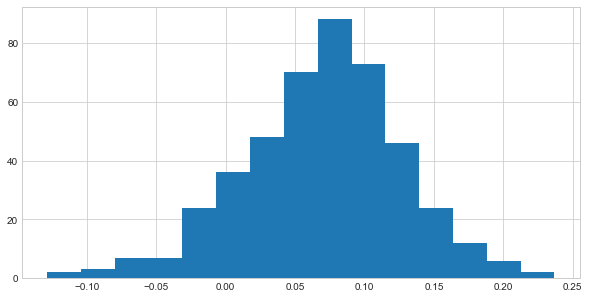

In [258]:
plt.figure(figsize=(10,5))
plt.hist(gini_preds_df['diff'], bins=15)
plt.show()

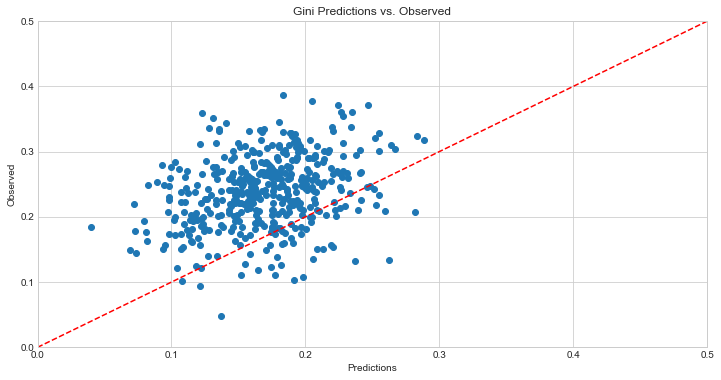

In [260]:
plt.figure(figsize=(12,6))
plt.title('Gini Predictions vs. Observed')
plt.xlabel('Predictions')
plt.ylabel('Observed')
plt.xlim(0,0.5)
plt.ylim(0,0.5)
plt.plot(plt.xlim(), plt.ylim(), ls="--", c="r")
plt.scatter(gini_preds_df['gini_pred'], gini_preds_df['gini_true'])
plt.show()

In [262]:
np.corrcoef(gini_preds_df['gini_pred'], gini_preds_df['gini_true'])

array([[ 1.        ,  0.30530655],
       [ 0.30530655,  1.        ]])

In [263]:
last_years_gini = []
last_years_wins = []
for i in range(len(gini_preds_df)):
    yr = gini_preds_df.iloc[i].yr
    team = gini_preds_df.iloc[i].team
    print yr, team

    try:
        l_gini = s_res[(s_res['abbr'] == team) & (s_res['yr'] == yr-1)]['gini'].values[0]
        l_wins = s_res[(s_res['abbr'] == team) & (s_res['yr'] == yr-1)]['W'].values[0]
    except IndexError:
        l_gini = None
        l_wins = None
        
    last_years_gini.append(l_gini)
    last_years_wins.append(l_wins)

2017.0 BOS
2017.0 CLE
2017.0 TOR
2017.0 WAS
2017.0 ATL
2017.0 MIL
2017.0 IND
2017.0 CHI
2017.0 MIA
2017.0 DET
2017.0 CHH
2017.0 NYK
2017.0 ORL
2017.0 PHI
2017.0 BRK
2017.0 GSW
2017.0 SAS
2017.0 HOU
2017.0 UTA
2017.0 LAC
2017.0 OKC
2017.0 MEM
2017.0 POR
2017.0 DEN
2017.0 NOP
2017.0 DAL
2017.0 SAC
2017.0 MIN
2017.0 LAL
2017.0 PHO
2016.0 CLE
2016.0 TOR
2016.0 MIA
2016.0 ATL
2016.0 CHH
2016.0 BOS
2016.0 IND
2016.0 DET
2016.0 CHI
2016.0 WAS
2016.0 ORL
2016.0 MIL
2016.0 NYK
2016.0 BRK
2016.0 PHI
2016.0 GSW
2016.0 SAS
2016.0 OKC
2016.0 LAC
2016.0 POR
2016.0 DAL
2016.0 MEM
2016.0 HOU
2016.0 UTA
2016.0 DEN
2016.0 SAC
2016.0 NOP
2016.0 MIN
2016.0 PHO
2016.0 LAL
2015.0 TOR
2015.0 BOS
2015.0 BRK
2015.0 PHI
2015.0 NYK
2015.0 CLE
2015.0 CHI
2015.0 MIL
2015.0 IND
2015.0 DET
2015.0 ATL
2015.0 WAS
2015.0 MIA
2015.0 CHH
2015.0 ORL
2015.0 POR
2015.0 OKC
2015.0 UTA
2015.0 DEN
2015.0 MIN
2015.0 GSW
2015.0 LAC
2015.0 PHO
2015.0 SAC
2015.0 LAL
2015.0 HOU
2015.0 MEM
2015.0 SAS
2015.0 DAL
2015.0 NOP
2014.0 TOR

In [264]:
len(last_years_gini)

448

In [265]:
gini_preds_df['l_gini'] = last_years_gini
gini_preds_df['l_wins'] = last_years_wins

In [266]:
gini_preds_df.head()

,gini_pred,gini_true,team,yr,diff,l_gini,l_wins
0,0.156066,0.211476,BOS,2017.0,0.055410,0.205388,48.0
1,0.139466,0.292304,CLE,2017.0,0.152838,0.240441,57.0
2,0.133884,0.258728,TOR,2017.0,0.124845,0.242026,56.0
3,0.183550,0.329842,WAS,2017.0,0.146291,0.217080,41.0
4,0.175990,0.239535,ATL,2017.0,0.063545,0.226271,48.0


In [267]:
gini_preds_df.to_excel('data/gini_preds_df_new_model.xlsx')

In [268]:
np.corrcoef(gini_preds_df['gini_pred'], gini_preds_df['gini_true'])

array([[ 1.        ,  0.30530655],
       [ 0.30530655,  1.        ]])

In [271]:
gini_preds_df[gini_preds_df['l_gini'] != gini_preds_df['l_gini']]

,gini_pred,gini_true,team,yr,diff,l_gini,l_wins
119,0.197370,0.203475,NOP,2014.0,0.006106,NaN,NaN
121,0.187234,0.233589,BRK,2013.0,0.046355,NaN,NaN
259,0.167826,0.330732,OKC,2009.0,0.162906,NaN,NaN
373,0.069102,0.149273,CHH,2005.0,0.080171,NaN,NaN
428,0.154723,0.309169,NOH,2003.0,0.154447,NaN,NaN


In [272]:
gini_preds_df_full = gini_preds_df[gini_preds_df['l_gini'] == gini_preds_df['l_gini']]

In [273]:
np.corrcoef(gini_preds_df_full['l_gini'], gini_preds_df_full['gini_true'])

array([[ 1.        ,  0.31555811],
       [ 0.31555811,  1.        ]])

## Usage for each player

In [371]:
yr = 2015
season_df = pd.read_excel('data/season_data/season_data_' + str(2015) + '.xlsx')

In [374]:
def get_player_usg(i, season_df):
    player = season_df['id'].iloc[i]
    team = season_df['team'].iloc[i]
    team_df = season_df[season_df['team'] == team]
    usgs = calculate_weighted_usg_2(team_df)
    usg_dict = {k:v for k, v in usgs}
    #print player, usg_dict[player]
    return usg_dict[player]

In [373]:
season_df['id'].iloc[3]

u'adrieje01'

In [375]:
get_player_usg(3, season_df)

0.009335818748741216

In [376]:
usg_lst = []
season_df = pd.read_excel('data/season_data/season_data_' + str(2015) + '.xlsx')
for i in range(len(season_df)):
    usg_lst.append(get_player_usg(i, season_df))

In [380]:
season_df['weighted_usg'] = usg_lst

In [384]:
season_df.to_excel('data/season_data/season_data_' + str(2015) + '.xlsx')

In [385]:
for yr in range(2003,2018):
    usg_lst = []
    season_df = pd.read_excel('data/season_data/season_data_' + str(yr) + '.xlsx')
    for i in range(len(season_df)):
        usg_lst.append(get_player_usg(i, season_df))
    season_df['weighted_usg'] = usg_lst
    season_df.to_excel('data/season_data/season_data_' + str(yr) + '.xlsx')

In [401]:
yr = 2002
usg_lst = []
season_df = pd.read_excel('data/season_data/season_data_' + str(yr) + '.xlsx')
for i in range(len(season_df)):
    usg_lst.append(get_player_usg(i, season_df))
season_df['weighted_usg'] = usg_lst
season_df.to_excel('data/season_data/season_data_' + str(yr) + '.xlsx')

## Match up players with last year's usage

In [74]:
#yr = 2017
frames = []
for yr in range(2003,2018):
    season_df = pd.read_excel('data/season_data/season_data_' + str(yr) + '.xlsx')
    frames.append(season_df)
df = pd.concat(frames)

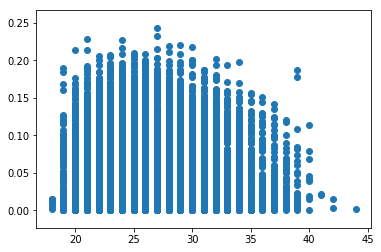

In [75]:
plt.scatter(df['age'], df['weighted_usg'])
plt.show()

In [139]:
df.columns

Index([u'G', u'GS', u'age', u'ast', u'blk', u'drb', u'efg', u'fg', u'fg2',
       u'fg2_pct', u'fg2a', u'fg3', u'fg3_pct', u'fg3a', u'fg_pct', u'fga',
       u'ft', u'ft_pct', u'fta', u'id', u'mp', u'orb', u'pf', u'player',
       u'pos', u'pts', u'stl', u'team', u'tov', u'trb', u'yr', u'weighted_usg',
       u'prev_weighted_usg'],
      dtype='object')

In [140]:
np.unique(df['pos'])

array([u'C', u'C-PF', u'C-SF', u'PF', u'PF-C', u'PF-SF', u'PG', u'PG-SF',
       u'PG-SG', u'SF', u'SF-PF', u'SF-SG', u'SG', u'SG-PF', u'SG-PG',
       u'SG-SF'], dtype=object)

In [135]:
player_df = df[df['id'] == 'antetgi01']

In [157]:
pos_df = df[df['pos'] == 'C']

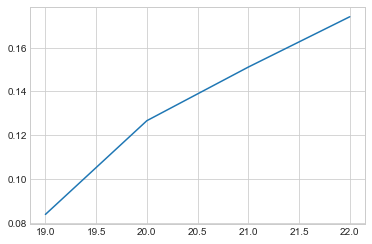

In [158]:
plt.plot(player_df['age'], player_df['weighted_usg'])
plt.show()

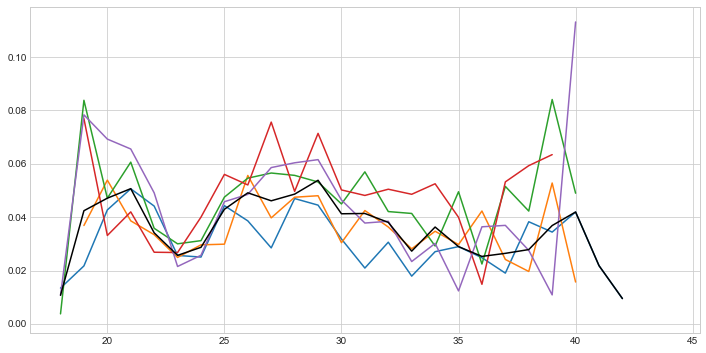

In [169]:
means = []
medians = []
for age in range(18,46):
    age_df = pos_df[pos_df['age'] == age]
    means.append(np.mean(age_df['weighted_usg']))
    medians.append(np.median(age_df['weighted_usg']))

plt.figure(figsize=(12,6))
#plt.scatter(pos_df['age'], pos_df['weighted_usg'])

for pos in ['C','PF','SF','SG','PG']:
    means = []
    medians = []
    pos_df = df[df['pos'] == pos]
    for age in range(18,46):
        age_df = pos_df[pos_df['age'] == age]
        means.append(np.mean(age_df['weighted_usg']))
        medians.append(np.median(age_df['weighted_usg']))
    plt.plot(range(18,46), medians)
    
means = []
medians = []
for age in range(18,46):
    age_df = df[df['age'] == age]
    means.append(np.mean(age_df['weighted_usg']))
    medians.append(np.median(age_df['weighted_usg']))
plt.plot(range(18,46), medians, c='black')
#plt.plot(pos_df['age'], medians)
plt.show()

In [111]:
df_high = df[df['weighted_usg'] > 0.09]

In [151]:
means = []
medians = []
for age in range(18,46):
    age_df = df_high[df_high['age'] == age]
    means.append(np.mean(age_df['weighted_usg']))
    medians.append(np.median(age_df['weighted_usg']))

In [154]:
medians

[nan,
 0.11100487837041251,
 0.13075859875270099,
 0.119780676330245,
 0.1238508917203635,
 0.12213650451298499,
 0.12290332415444599,
 0.12683854462510852,
 0.1192903754539435,
 0.12375012680451,
 0.12473408733123101,
 0.12175056718661099,
 0.123471665301758,
 0.11818167514738551,
 0.119640094363491,
 0.12033765307170501,
 0.109563486032612,
 0.112063511506881,
 0.116477504864808,
 0.113484805426997,
 0.11804968523710201,
 0.178141057894937,
 0.11311500305693201,
 nan,
 nan,
 nan,
 nan,
 nan]

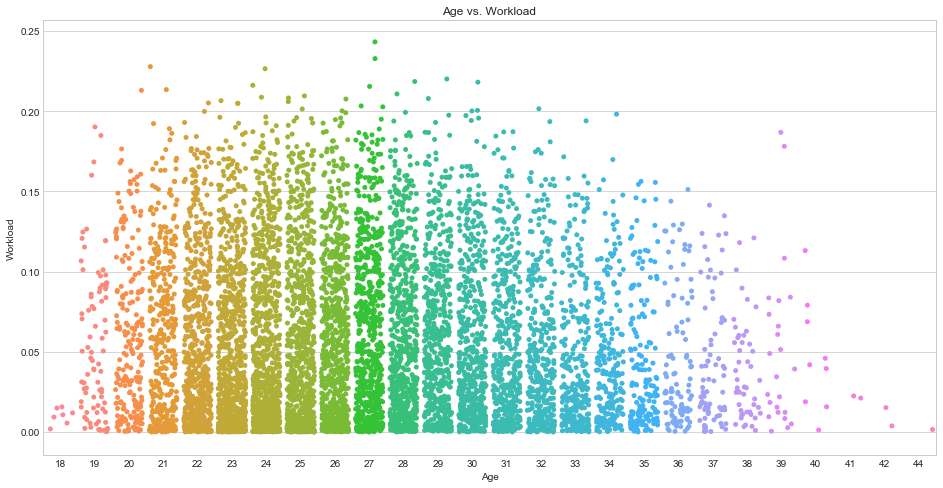

In [161]:
import seaborn as sns
sns.set_style("whitegrid")
plt.figure(figsize=(16,8))
#sns.stripplot(x="age", y="weighted_usg", data=df, jitter=0.2, 
#              order=[str(i) for i in range(18,45)])

sns.stripplot(x="age", y="weighted_usg", data=df, jitter=0.4)
#plt.plot(range(18,46), means, c='b', linewidth=2, zorder=10)
#plt.plot(range(18,46), medians, c='r', linewidth=2, zorder=10)
plt.ylabel('Workload')
plt.xlabel('Age')
plt.title('Age vs. Workload')

plt.show()

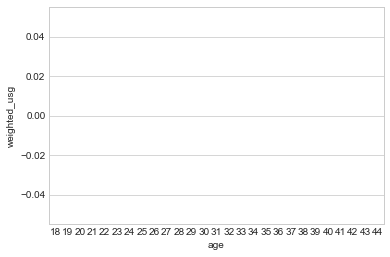

In [546]:
sns.stripplot(x="age", y="weighted_usg", data=df, jitter=0.12, 
              order=[str(i) for i in range(18,45)])

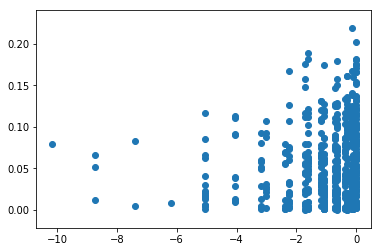

In [541]:
plt.scatter([-(a**2) for a in stats.zscore(season_df['age'])], season_df['weighted_usg'])
plt.show()

In [397]:
for i in range(19,41):
    age_df = season_df[season_df['age'] == i]
    print i, np.mean(age_df['weighted_usg']), np.median(age_df['weighted_usg'])

19 0.0455711903305 0.02694512339
20 0.0447057158739 0.026559803583
21 0.0558539486 0.0510887576619
22 0.0358102694011 0.0195731347096
23 0.0453241945332 0.0361851307348
24 0.0483832084363 0.0351732074697
25 0.0433648354809 0.0353018457323
26 0.0772126737678 0.0759747953827
27 0.0680855682061 0.0602889672149
28 0.0593379199153 0.0317611582695
29 0.0555543137833 0.0637180082193
30 0.0542430460354 0.0481447126959
31 0.0596000904909 0.0561592935153
32 0.0582536239873 0.0447266273245
33 0.0384536620319 0.0547474475395
34 0.0401431736902 0.0486595050431
35 0.0543283219565 0.0388305731806
36 0.0326467041578 0.0188390103532
37 0.00853203427178 0.00853203427178
38 0.0436997572319 0.0436997572319
39 0.0432196364607 0.0514363940928
40 0.0790662953444 0.0790662953444


In [398]:
season_df.head()

,G,GS,age,ast,blk,drb,efg,fg,fg2,fg2_pct,...,pf,player,pos,pts,stl,team,tov,trb,yr,weighted_usg
0,68,6,23,40,8,68,0.531,134,40,0.426,...,114,Alex Abrines,SG,406,37,OKC,33,86,2017,0.047907
1,38,1,26,18,15,95,0.521,70,33,0.413,...,67,Quincy Acy,PF,222,14,TOT,21,115,2017,0.009668
2,6,0,26,0,0,6,0.324,5,4,0.400,...,9,Quincy Acy,PF,13,0,DAL,2,8,2017,0.002432
3,32,1,26,18,15,89,0.542,65,29,0.414,...,58,Quincy Acy,PF,209,14,BRK,19,107,2017,0.023642
4,80,80,23,86,78,332,0.571,374,374,0.572,...,195,Steven Adams,C,905,89,OKC,146,613,2017,0.109469


In [430]:
yr = 2017
season_df = pd.read_excel('data/season_data/season_data_' + str(yr) + '.xlsx')
len(season_df)

595

In [431]:
last_season_df = pd.read_excel('data/season_data/season_data_' + str(yr-1) + '.xlsx')

In [432]:
season_df.iloc[1]['id']

u'acyqu01'

In [433]:
prev_usg = last_season_df[last_season_df['id'] == season_df.iloc[3].id]

In [434]:
prev_usg['weighted_usg'].values[0]

0.036718652756643003

In [450]:
for yr in range(2003,2018):
    season_df = pd.read_excel('data/season_data/season_data_' + str(yr) + '.xlsx')
    last_season_df = pd.read_excel('data/season_data/season_data_' + str(yr-1) + '.xlsx')
    prev_usg_lst = []
    for i in range(len(season_df)):
        prev_usg = last_season_df[last_season_df['id'] == season_df.iloc[i].id]
        if len(prev_usg) == 1:
            prev_usg_lst.append(prev_usg['weighted_usg'].values[0])
        else:
            prev_usg_lst.append(None)
    season_df['prev_weighted_usg'] = prev_usg_lst
    season_df.to_excel('data/season_data/season_data_' + str(yr) + '.xlsx')

In [436]:
len(prev_usg_lst)

595

In [437]:
season_df['prev_weighted_usg'] = prev_usg_lst

In [439]:
season_df.head(n=10)

,G,GS,age,ast,blk,drb,efg,fg,fg2,fg2_pct,...,player,pos,pts,stl,team,tov,trb,yr,weighted_usg,prev_weighted_usg
0,68,6,23,40,8,68,0.531,134,40,0.426,...,Alex Abrines,SG,406,37,OKC,33,86,2017,0.047907,NaN
1,38,1,26,18,15,95,0.521,70,33,0.413,...,Quincy Acy,PF,222,14,TOT,21,115,2017,0.009668,0.036719
2,6,0,26,0,0,6,0.324,5,4,0.400,...,Quincy Acy,PF,13,0,DAL,2,8,2017,0.002432,0.036719
3,32,1,26,18,15,89,0.542,65,29,0.414,...,Quincy Acy,PF,209,14,BRK,19,107,2017,0.023642,0.036719
4,80,80,23,86,78,332,0.571,374,374,0.572,...,Steven Adams,C,905,89,OKC,146,613,2017,0.109469,0.082987
5,61,45,31,78,6,116,0.514,185,123,0.457,...,Arron Afflalo,SG,515,21,SAC,42,125,2017,0.068534,0.113848
6,39,15,28,12,22,131,0.500,89,89,0.511,...,Alexis Ajinca,C,207,20,NOP,31,177,2017,0.027336,0.044005
7,62,0,28,25,23,107,0.523,45,45,0.523,...,Cole Aldrich,C,105,25,MIN,17,158,2017,0.019740,0.038858
8,72,72,31,139,88,351,0.488,500,477,0.480,...,LaMarcus Aldridge,PF,1243,46,SAS,98,523,2017,0.131592,0.131949
9,61,5,27,57,24,114,0.458,77,77,0.461,...,Lavoy Allen,PF,177,18,IND,29,219,2017,0.033932,0.066434


In [446]:
season_df_small = season_df[season_df['prev_weighted_usg'] == season_df['prev_weighted_usg']]
len(season_df_small)

441

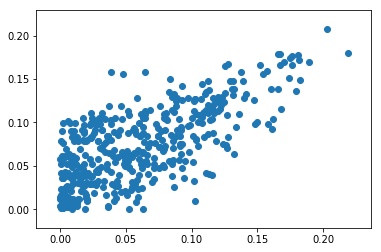

In [447]:
plt.scatter(season_df_small['weighted_usg'], season_df_small['prev_weighted_usg'])
plt.show()

In [448]:
print np.corrcoef(season_df_small['weighted_usg'], season_df_small['prev_weighted_usg'])
print np.corrcoef(season_df['weighted_usg'], season_df['prev_weighted_usg'])

[[ 1.          0.70280472]
 [ 0.70280472  1.        ]]
[[  1.  nan]
 [ nan  nan]]


In [199]:
gini_df = pd.read_excel('data/nba_results_gini_new.xlsx')

In [202]:
gini_df.head()

,Team,W,L,WL_pct,PW,PL,PS/G,PA/G,yr,abbr,playoffs,gini,alt_abbr
0,Boston Celtics,53,29,0.646,48,34,108.0,105.4,2017,BOS,3,0.211476,BOS
1,Cleveland Cavaliers,51,31,0.622,49,33,110.3,107.2,2017,CLE,4,0.292304,CLE
2,Toronto Raptors,51,31,0.622,52,30,106.9,102.6,2017,TOR,2,0.258728,TOR
3,Washington Wizards,49,33,0.598,46,36,109.2,107.4,2017,WAS,2,0.329842,WAS
4,Atlanta Hawks,43,39,0.524,39,43,103.2,104.0,2017,ATL,1,0.239535,ATL


In [203]:
gini_true = gini_df[(gini_df['alt_abbr'] == 'CHO') & (gini_df['yr'] == 2017)]['gini'].values[0]

In [204]:
gini_true

0.23040440543985599

## Generating some plots

In [170]:
df_full = pd.read_excel('data/season_data/season_data_full.xlsx')

In [236]:
len(df_full)

4722

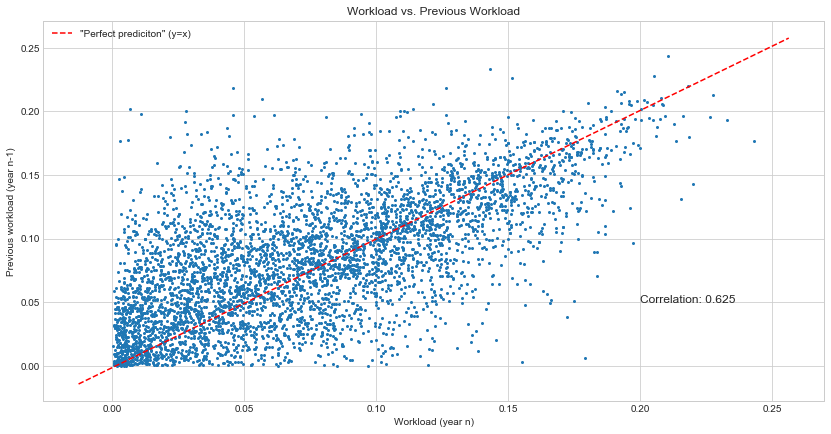

In [232]:
cor = np.corrcoef(df_full['weighted_usg'], df_full['prev_weighted_usg'])[0][1]
plt.figure(figsize=(14,7))
plt.scatter(df_full['weighted_usg'], df_full['prev_weighted_usg'], s=4)
plt.text(0.2, 0.05, 'Correlation: 0.625', fontsize=12)
plt.xlabel('Workload (year n)')
plt.ylabel('Previous workload (year n-1)')
plt.title('Workload vs. Previous Workload')
plt.plot(plt.xlim(), plt.ylim(), ls="--", c="r", label='lines')
plt.legend(labels=['"Perfect prediciton" (y=x)'])
plt.show()

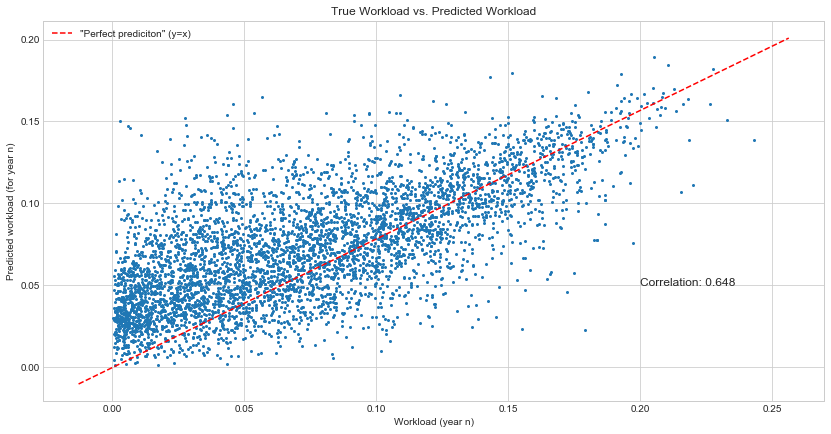

In [231]:
cor = np.corrcoef(df_full['weighted_usg'], df_full['full_preds'])[0][1]
plt.figure(figsize=(14,7))
plt.scatter(df_full['weighted_usg'], df_full['full_preds'], s=4)
plt.text(0.2, 0.05, 'Correlation: 0.648', fontsize=12)
plt.xlabel('Workload (year n)')
plt.ylabel('Predicted workload (for year n)')
plt.title('True Workload vs. Predicted Workload')
plt.plot(plt.xlim(), plt.ylim(), ls="--", c='r', label='lines')
plt.legend(labels=['"Perfect prediciton" (y=x)'])
plt.show()

In [199]:
df_full['resid'] = [true - pred for true, pred in zip(df_full['weighted_usg'], df_full['full_preds'])]

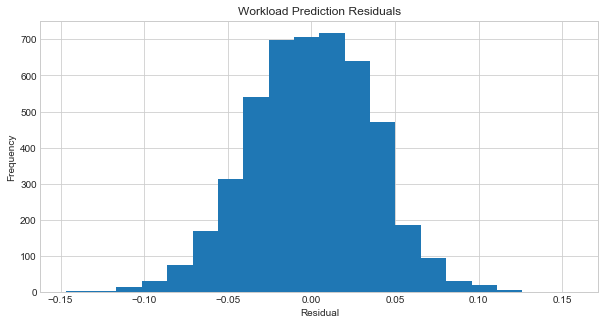

In [212]:
plt.figure(figsize=(10,5))
plt.hist(df_full['resid'], bins=20)
plt.title('Workload Prediction Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()

In [206]:
np.percentile(df_full['resid'], 2.5), np.percentile(df_full['resid'], 97.5)

(-0.073190477434044415, 0.07036054485567983)

In [209]:
np.percentile(df_full['resid'], 25), np.percentile(df_full['resid'], 75)

(-0.024848154070407365, 0.025528832638208574)

In [210]:
np.mean([abs(r) for r in df_full['resid']])

0.029479404313506187

In [234]:
np.mean([r**2 for r in df_full['resid']])

0.0013514573236683551

In [235]:
df_full[df_full['id'] == 'stoudam01']

,X__1,G,GS,age,ast,blk,drb,efg,fg,fg2,...,tov,trb,yr,weighted_usg,prev_weighted_usg,age2,z.age,z.age2,full_preds,resid
526,486,55,53,21,78,89,339,0.476,411,410,...,177,496,2004,0.122247,0.134965,441,-1.528004,2.334797,0.126724,-0.004477
839,487,80,80,22,131,130,494,0.560,747,744,...,189,713,2005,0.176790,0.122247,484,-1.283030,1.646165,0.114349,0.062440
1124,470,3,3,23,2,3,10,0.333,9,9,...,1,16,2006,0.003056,0.176790,529,-1.038055,1.077559,0.149971,-0.146915
1415,443,82,78,24,84,110,564,0.575,607,607,...,232,786,2007,0.155254,0.003056,576,-0.793081,0.628977,0.023508,0.131746
1740,498,79,79,25,118,163,541,0.592,714,709,...,174,719,2008,0.163737,0.155254,625,-0.548106,0.300420,0.128917,0.034820
2051,506,53,53,26,104,57,314,0.541,404,401,...,150,430,2009,0.109063,0.163737,676,-0.303131,0.091889,0.132350,-0.023287
2344,495,82,82,27,82,83,502,0.557,704,703,...,213,732,2010,0.170782,0.109063,729,-0.058157,0.003382,0.091073,0.079709
2666,526,78,78,28,202,150,438,0.505,744,734,...,250,636,2011,0.184870,0.170782,784,0.186818,0.034901,0.132717,0.052153
2963,459,47,47,29,52,45,261,0.487,316,311,...,112,367,2012,0.110211,0.184870,841,0.431792,0.186445,0.140688,-0.030477
3975,561,36,14,32,37,34,162,0.543,169,169,...,63,245,2015,0.046928,0.080395,1024,1.166716,1.361227,0.061397,-0.014469


In [219]:
df_full.sort_values(['resid'])[['team','yr','id','resid']]

,team,yr,id,resid
1124,PHO,2006,stoudam01,-0.146915
3789,IND,2015,georgpa01,-0.141350
1929,DEN,2009,iversal01,-0.139653
3390,LAL,2014,bryanko01,-0.130803
1468,WAS,2008,arenagi01,-0.124507
506,CHI,2004,roseja01,-0.119960
1854,NYK,2009,crawfja01,-0.117204
1288,PHI,2007,iversal01,-0.114984
879,IND,2005,artesro01,-0.114748
2022,CHH,2009,richaja01,-0.112684


In [237]:
df_full.columns

Index([             u'X__1',                 u'G',                u'GS',
                     u'age',               u'ast',               u'blk',
                     u'drb',               u'efg',                u'fg',
                     u'fg2',           u'fg2_pct',              u'fg2a',
                     u'fg3',           u'fg3_pct',              u'fg3a',
                  u'fg_pct',               u'fga',                u'ft',
                  u'ft_pct',               u'fta',                u'id',
                      u'mp',               u'orb',                u'pf',
                  u'player',               u'pos',               u'pts',
                     u'stl',              u'team',               u'tov',
                     u'trb',                u'yr',      u'weighted_usg',
       u'prev_weighted_usg',              u'age2',             u'z.age',
                  u'z.age2',        u'full_preds',             u'resid'],
      dtype='object')

## Gini predictions

In [280]:
df = pd.read_excel('data/gini_preds_final.xlsx')

In [295]:
min(df['full_preds'])

0.18541846416727

In [290]:
df['resid'] = [true - pred for true, pred in zip(df['gini_true'], df['full_preds'])]

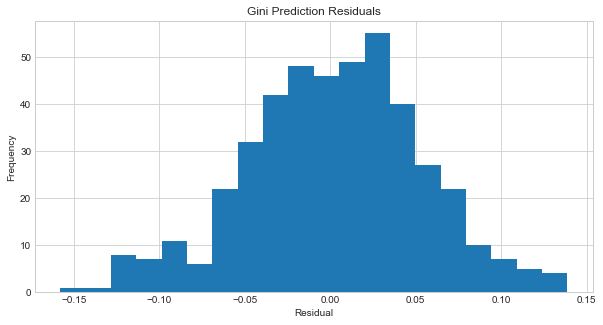

In [309]:
plt.figure(figsize=(10,5))
plt.hist(df['resid'], bins=20)
plt.title('Gini Prediction Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()

In [297]:
np.percentile(df['resid'], 2.5), np.percentile(df['resid'], 97.5)

(-0.10534990221997108, 0.10648656988059356)

In [298]:
np.percentile(df['resid'], 25), np.percentile(df['resid'], 75)

(-0.031138467115179855, 0.036228416719742709)

In [299]:
np.mean([abs(r) for r in df['resid']])

0.04087163841168185

In [300]:
np.mean([r**2 for r in df['resid']])

0.0026497919750423883

In [283]:
np.corrcoef(df['gini_true'], df['l_gini'])

array([[ 1.        ,  0.31555811],
       [ 0.31555811,  1.        ]])

In [285]:
np.corrcoef(df['gini_true'], df['full_preds'])

array([[ 1.        ,  0.34608155],
       [ 0.34608155,  1.        ]])

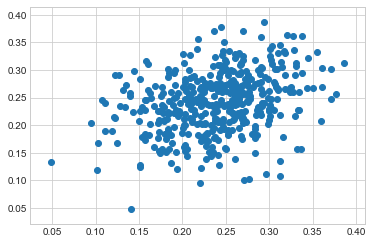

In [287]:
plt.scatter(df['gini_true'], df['l_gini'])
plt.show()

In [ ]:
> cor(test$gini_true, test$l_gini)
[1] 0.3442777
> cor(test$gini_true, preds)
[1] 0.4026052

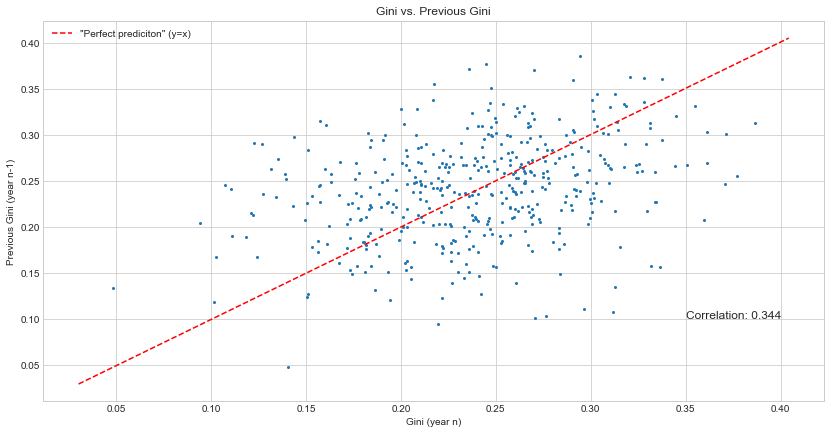

In [307]:
plt.figure(figsize=(14,7))
plt.scatter(df['gini_true'], df['l_gini'], s=4)
plt.text(0.35, 0.1, 'Correlation: 0.344', fontsize=12)
plt.xlabel('Gini (year n)')
plt.ylabel('Previous Gini (year n-1)')
plt.title('Gini vs. Previous Gini')
plt.plot(plt.xlim(), plt.ylim(), ls="--", c="r", label='lines')
plt.legend(labels=['"Perfect prediciton" (y=x)'])
plt.show()

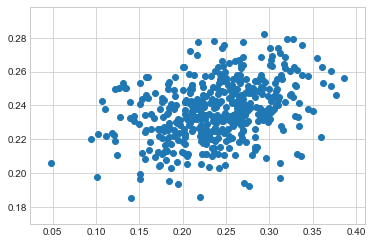

In [288]:
plt.scatter(df['gini_true'], df['full_preds'])
plt.show()

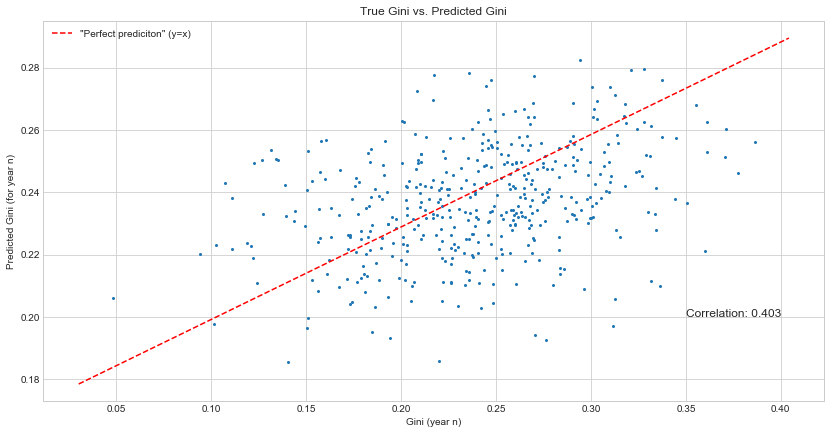

In [308]:
plt.figure(figsize=(14,7))
plt.scatter(df['gini_true'], df['full_preds'], s=4)
plt.text(0.35, 0.2, 'Correlation: 0.403', fontsize=12)
plt.xlabel('Gini (year n)')
plt.ylabel('Predicted Gini (for year n)')
plt.title('True Gini vs. Predicted Gini')
plt.plot(plt.xlim(), plt.ylim(), ls="--", c="r", label='lines')
plt.legend(labels=['"Perfect prediciton" (y=x)'])
plt.show()

In [ ]:
plt.figure(figsize=(14,7))
plt.scatter(df['gini_true'], df['l_gini'], s=4)
plt.text(0.2, 0.05, 'Correlation: 0.344', fontsize=12)
plt.xlabel('Workload (year n)')
plt.ylabel('Previous workload (year n-1)')
plt.title('Workload vs. Previous Workload')
plt.plot(plt.xlim(), plt.ylim(), ls="--", c="r", label='lines')
plt.legend(labels=['"Perfect prediciton" (y=x)'])
plt.show()

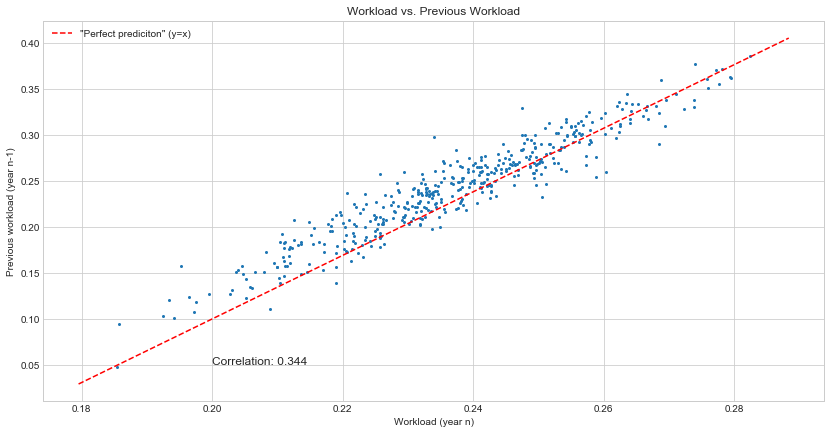

In [305]:
plt.figure(figsize=(14,7))
plt.scatter(df['full_preds'], df['l_gini'], s=4)
plt.text(0.2, 0.05, 'Correlation: 0.344', fontsize=12)
plt.xlabel('Workload (year n)')
plt.ylabel('Previous workload (year n-1)')
plt.title('Workload vs. Previous Workload')
plt.plot(plt.xlim(), plt.ylim(), ls="--", c="r", label='lines')
plt.legend(labels=['"Perfect prediciton" (y=x)'])
plt.show()